# Fashion MNIST Image Classification
## ST1504 Deep Learning CA1 Part A

##### Name: Haja Amir Rahman
##### Class: DAAA/FT/2B/06
##### Admin Number: P2100803

## References:
- [ResNet50](https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691)
- [Flipping & cropping images](https://www.tensorflow.org/api_docs/python/tf/image/flip_left_right)

<h4><b>Notebook Contents:</b></h4>
1. Data Exploration/Background Research<br>
2. Data Augmentation/Feature Engineering<br>
3. Modelling & Evaluation<br>
4. Model Improvement<br>

<h3><b>1. Data Exploration/ Background Research</b></h3>

The Fashion MNIST Dataset is a dataset of Zalando's images, with 60000 examples for training and 10000 examples for testing. Each example is a 28x28 greyscale image, with 10 associated labels.

* Import all modules
* Load dataset
* Rescale test and train images

In [19]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:

import keras
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import pandas as pd
# import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras import layers
from tensorflow.keras import Sequential
from matplotlib import pyplot

In [21]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 
'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Normalization

In [22]:
(x_train,y_train),(x_test,y_test)= tf.keras.datasets.fashion_mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1, shuffle=False)
x_test = x_test/255
x_val = x_val/255
x_train = x_train/255

In [23]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(54000, 28, 28) (54000,)
(6000, 28, 28) (6000,)
(10000, 28, 28) (10000,)


* 54000 images of 28 pixels by 28 pixels for training and 54000 labels to pair with the images

* 6000 images of 28 x 28 for validation and 6000 labels

* 10000 images of 28 pixels by 28 pixels for testing and 10000 labels to pair with the images

- 28x28 image loaded

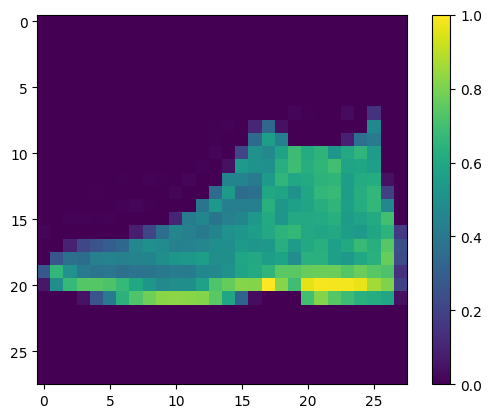

In [24]:
plt.figure()
plt.imshow(x_test[0])
plt.colorbar()
plt.grid(False)
plt.show()

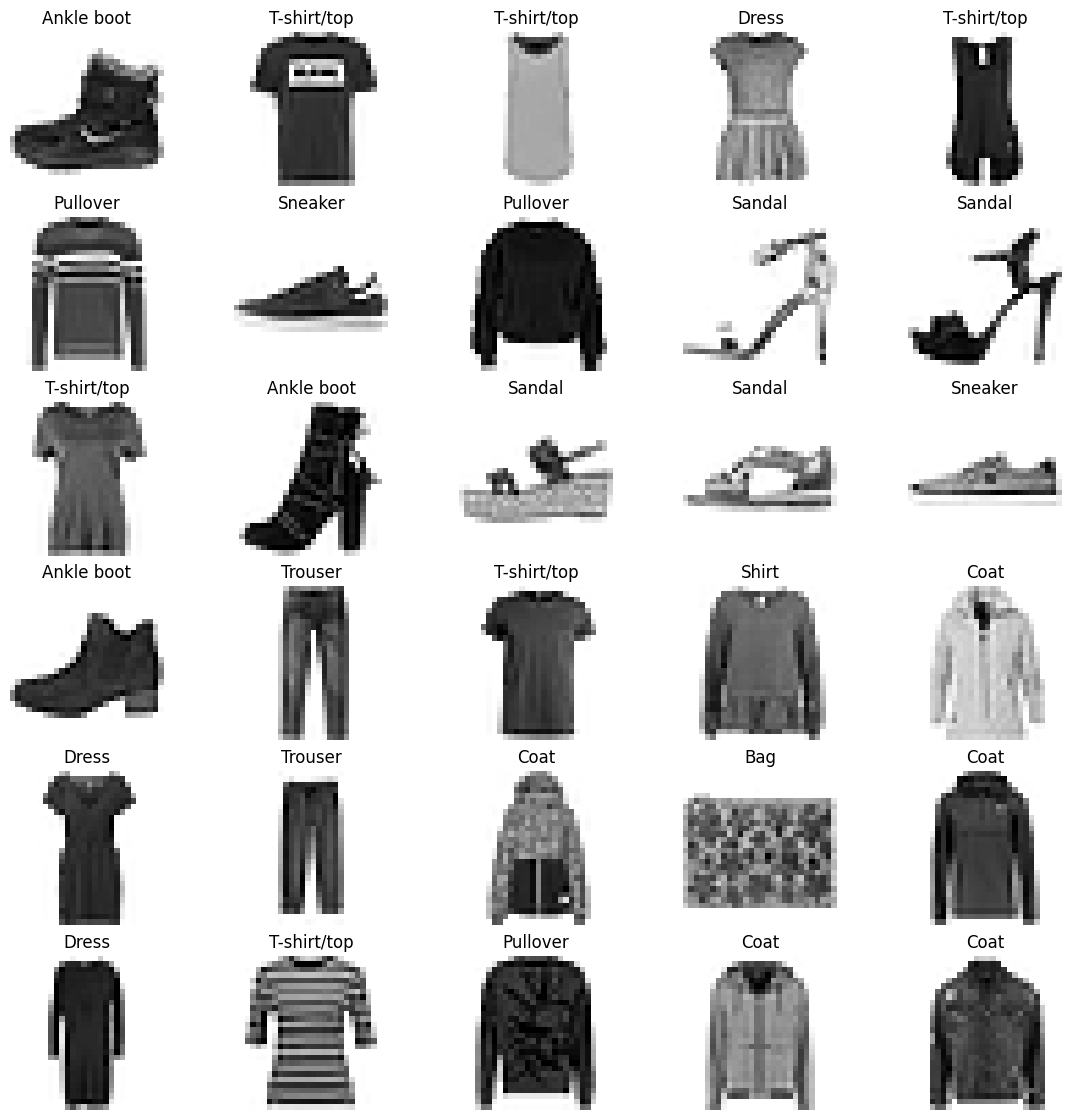

In [25]:
import matplotlib.pyplot as plt

NUM_ROW = 6               # CHANGE THIS
NUM_COL = 5               # CHANGE THIS
WIDTH = 14                # CHANGE THIS
HEIGHT = 14               # CHANGE THIS

fig, ax = plt.subplots(NUM_ROW, NUM_COL, figsize=(WIDTH, HEIGHT))
row_i = 0
col_i = 0

for i in range(30):        # CHANGE THIS

    img = x_train[i]
    label = y_train[i]
    
    ax[row_i, col_i].imshow(img, cmap=plt.cm.binary)
    ax[row_i, col_i].set_title(f"{class_names[label]}")
    ax[row_i, col_i].axis("off")

    col_i += 1
    if col_i > NUM_COL-1:
        row_i += 1
        col_i = 0
        
plt.show()

<h2>Objectives/Tasks</h2>

* Be able to accurately identify the test images fed to the model
* Get highest possible accuracy and loss (>95% accuracy)
* Use regularization methods, data augmentation and different model architecture to reduce overfitting while improving accuracy and loss

<h3><b>2. Data Augmentation</h3></b>

* Defined function to execute flipping and tilting on training images

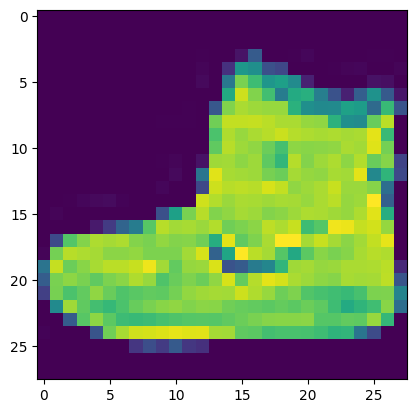

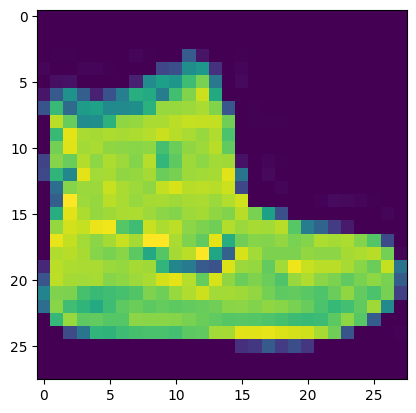

In [26]:
plt.imshow(x_train[0])
plt.show()
plt.imshow(tf.image.flip_left_right(x_train[0].reshape((*x_train[0].shape,1))))
plt.show()

(54000, 28, 28)


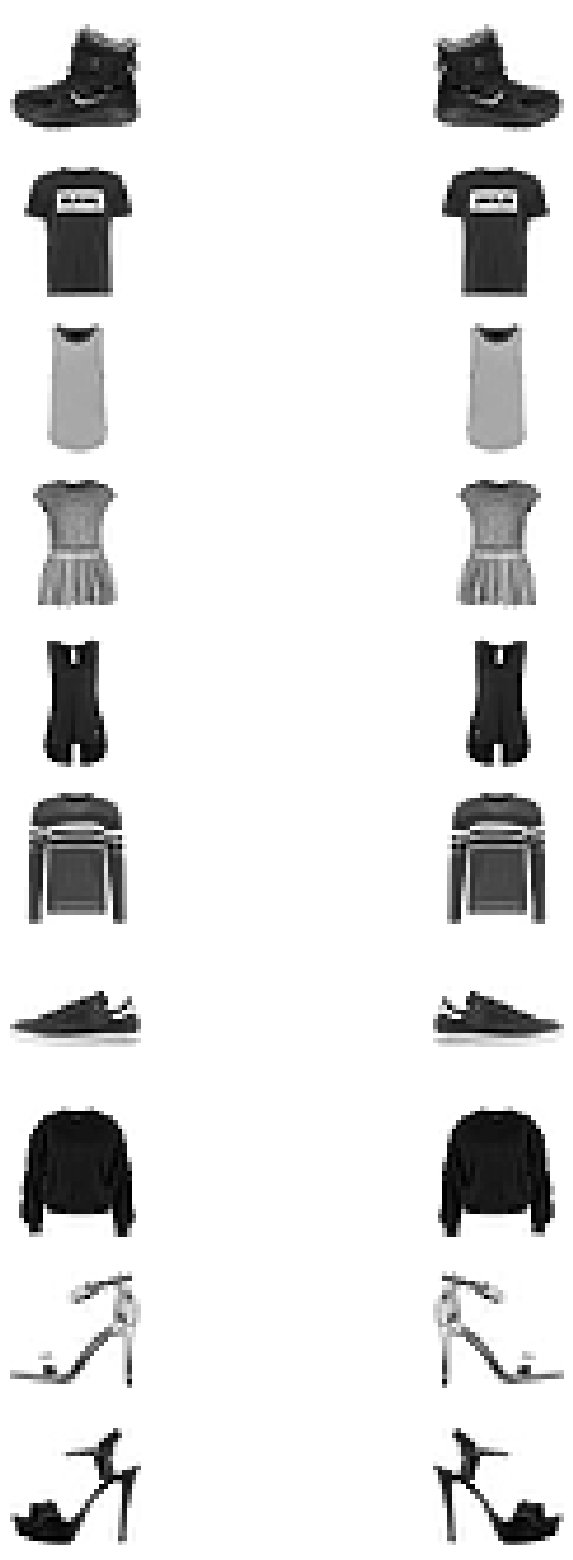

In [27]:
def flipall(images):
    images = images.reshape((*images.shape,1))
    images = tf.image.flip_left_right(images).numpy()
    images = images.reshape(images.shape[:3])

    return images
    
x_train_flipped = flipall(x_train)
print(x_train_flipped.shape)

WIDTH = 10                # CHANGE THIS
HEIGHT = 20               # CHANGE THIS

fig, ax = plt.subplots(10, 2, figsize=(WIDTH, HEIGHT))

for i in range(10):        # CHANGE THIS
    
    img1 = x_train[i]    
    ax[i, 0].imshow(img1, cmap=plt.cm.binary)
    ax[i, 0].axis("off")
    
    img2 = x_train_flipped[i]    
    ax[i, 1].imshow(img2, cmap=plt.cm.binary)
    ax[i, 1].axis("off")
        
plt.show()
    

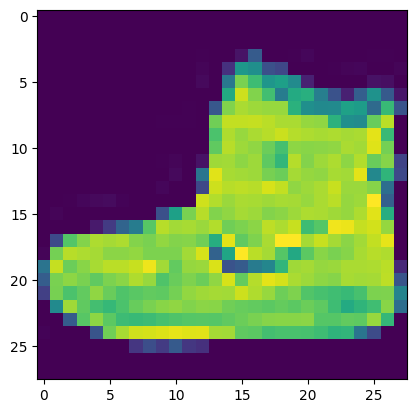

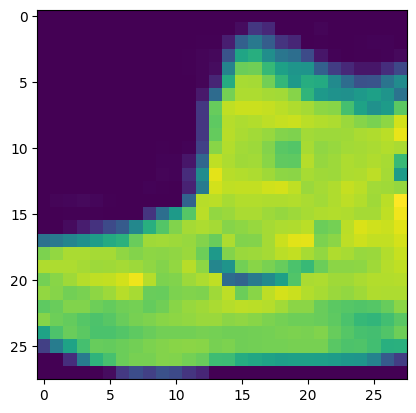



(54000, 28, 28)


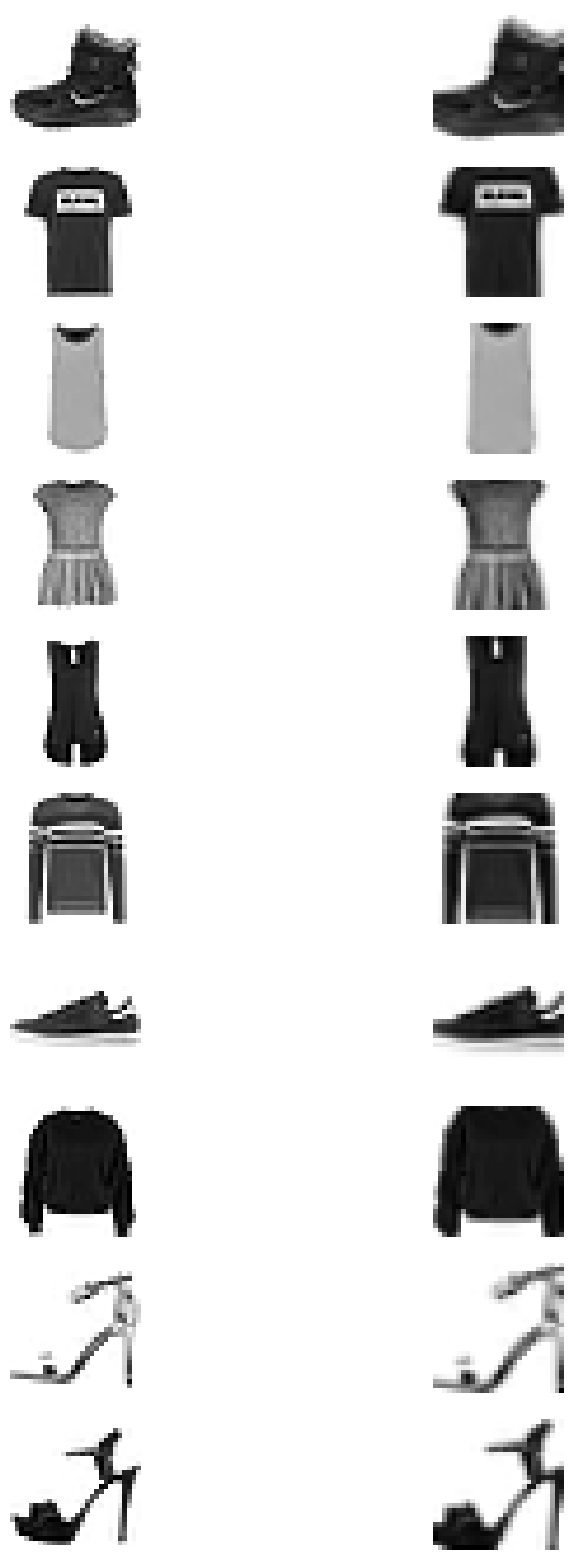

In [28]:
def cropall(images):
    images = images.reshape((*images.shape,1))
    images = tf.image.central_crop(images, 0.8)
    images = tf.image.resize(images, (28,28))
    images = images.numpy().reshape(images.shape[:3])

    return images

cropped_test = cropall(x_train[0])
plt.imshow(x_train[0])
plt.show()
plt.imshow(cropped_test)
plt.show()

print("\n"+"="*50+"\n")
    
x_train_cropped = cropall(x_train)
print(x_train_cropped.shape)

WIDTH = 10                # CHANGE THIS
HEIGHT = 20               # CHANGE THIS

fig, ax = plt.subplots(10, 2, figsize=(WIDTH, HEIGHT))

for i in range(10):        # CHANGE THIS
    
    img1 = x_train[i]    
    ax[i, 0].imshow(img1, cmap=plt.cm.binary)
    ax[i, 0].axis("off")
    
    img2 = x_train_cropped[i]    
    ax[i, 1].imshow(img2, cmap=plt.cm.binary)
    ax[i, 1].axis("off")
        
plt.show()

# Simple Baseline Model

In [29]:
model = Sequential([
    layers.Conv2D(32, (2,2), activation="relu", input_shape=(28, 28, 1)),
    layers.Flatten(), # 2d to 1d
    layers.Dense(16, activation="relu"),
    layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(model.summary())

baseline_history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))
baseline_history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         (None, 27, 27, 32)        160       
                                                                 
 flatten (Flatten)           (None, 23328)             0         
                                                                 
 dense_9 (Dense)             (None, 16)                373264    
                                                                 
 dense_10 (Dense)            (None, 10)                170       
                                                                 
Total params: 373,594
Trainable params: 373,594
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
1688/1688 [==============================] - 17s 6ms/step - loss: 0.4736 - accuracy: 0.8350 - val_loss: 0.3575 - val_accuracy: 0.8707
Epoch 2/20
1688/1688 [==========

In [30]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.5576 - accuracy: 0.8946


[0.5576196908950806, 0.894599974155426]

## Baseline Training and validation Accuracy

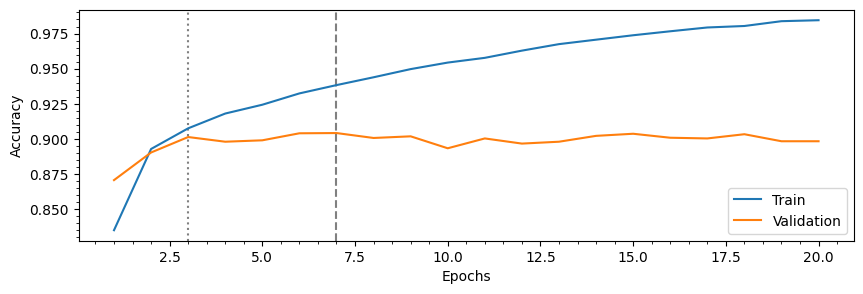

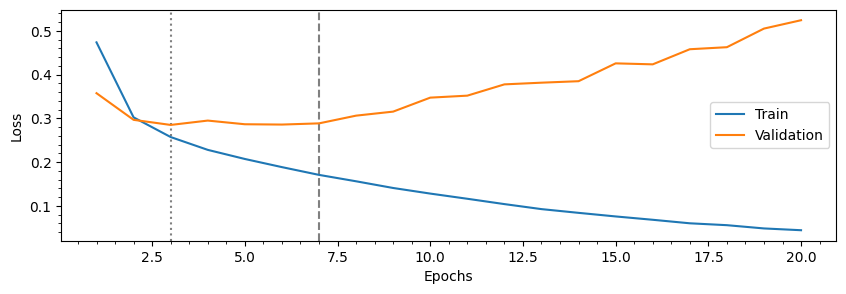

In [32]:
max_val_acc_epoch = np.argmax(list(baseline_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(baseline_history.history['val_loss']))+1
epochs = range(1, len(baseline_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_history.history['accuracy'], label='Train')
plt.plot(epochs,baseline_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_history.history['loss'], label='Train')
plt.plot(epochs,baseline_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

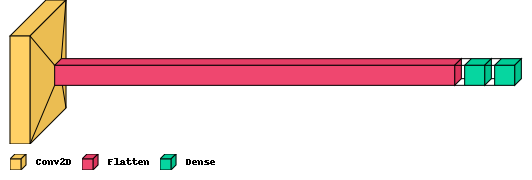

In [33]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

In [34]:
model.save_weights("models/fashion-baseline-model.h5")

#### baseline model containing simple Conv2D layer gets testing accuracy of 90%

<h3><b>3. Modelling & Evaluation</h3></b>

<h3>Metrics Used</h3>

* Top 1 accuracy
* Top 3 accuracy
* Loss

# Own model

In [35]:
own_model = Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28, 28, 1)),    
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.Conv2D(64, (3,3), activation="relu"),    
    layers.MaxPooling2D((2, 2)),

    # layers.Conv2D(128, (3,3), activation="relu"),    
    # layers.MaxPooling2D((2, 2)),
    
    # layers.Conv2D(64, (3,3), activation="relu"),
    # layers.GlobalAveragePooling2D(),
    
    layers.Dropout(0.1),
    
    layers.Flatten(), # 2d to 1d
    layers.Dense(64, activation="relu"),
    layers.Dense(10)
])

own_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(own_model.summary())

history = own_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))
history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_109 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_110 (Conv2D)         (None, 11, 11, 64)        18496     
                                                                 
 conv2d_111 (Conv2D)         (None, 9, 9, 64)          36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 4, 4, 64)         

In [36]:
own_model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.2568 - accuracy: 0.9138


[0.25678643584251404, 0.9138000011444092]

## Own model Training and validation Accuracy & Loss

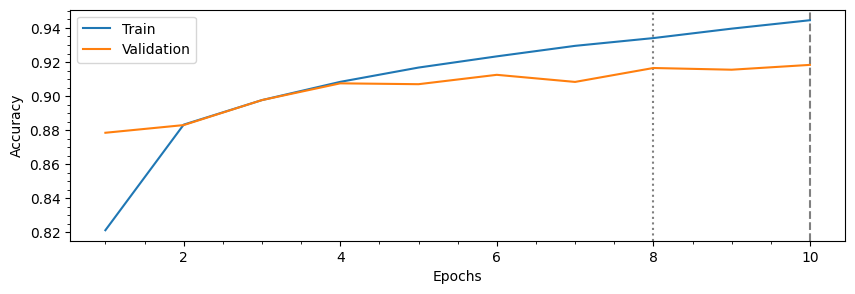

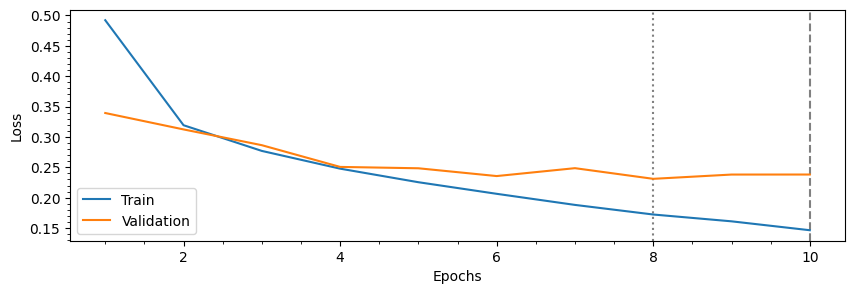

In [37]:
max_val_acc_epoch = np.argmax(list(history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(history.history['val_loss']))+1
epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,history.history['accuracy'], label='Train')
plt.plot(epochs,history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,history.history['loss'], label='Train')
plt.plot(epochs,history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

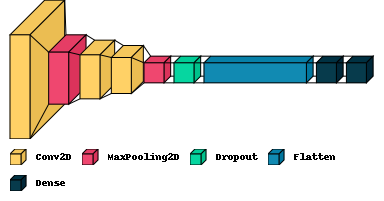

In [39]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(own_model, legend=True)

In [40]:
own_model.save_weights("models/fashion-own-model.h5")

<h3><b>4. Model Improvement with augmented data</h3></b>

In [41]:
x_train_augmented = list(x_train) + list(x_train_flipped) + list(x_train_cropped)
x_train_augmented = np.array(x_train_augmented)

y_train_augmented = np.array(list(y_train) * 3)

x_train_augmented.shape, y_train_augmented.shape

((162000, 28, 28), (162000,))

In [43]:
baseline_augmented_model = Sequential([
    layers.Conv2D(64, (4,4), activation="relu", input_shape=(28, 28, 1)),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(), # 2d to 1d
    layers.Dense(128, activation="relu"),
    layers.Dense(10)
])

#copy pasted from documentation
baseline_augmented_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(baseline_augmented_model.summary())

baseline_augmented_history = baseline_augmented_model.fit(x_train_augmented, y_train_augmented, epochs=5, validation_data=(x_val, y_val))
baseline_augmented_history

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_112 (Conv2D)         (None, 25, 25, 64)        1088      
                                                                 
 flatten_2 (Flatten)         (None, 40000)             0         
                                                                 
 dense_13 (Dense)            (None, 128)               5120128   
                                                                 
 dense_14 (Dense)            (None, 10)                1290      
                                                                 
Total params: 5,122,506
Trainable params: 5,122,506
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
5063/5063 [==============================] - 35s 7ms/step - loss: 0.3582 - accuracy: 0.8691 - val_loss: 0.2905 - val_accuracy: 0.8998
Epoch 2/5
5063/5063 [======

In [44]:
baseline_augmented_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3891 - accuracy: 0.9030


[0.38913753628730774, 0.902999997138977]

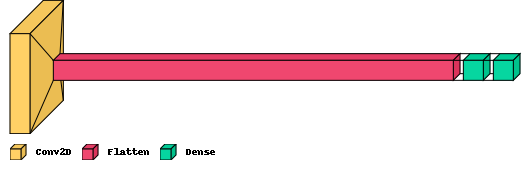

In [45]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(baseline_augmented_model, legend=True)

In [46]:
baseline_augmented_model.save_weights("models/fashion_baseline_augmented_model.h5")

In [47]:
own_augmented_model = Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28, 28, 1)),    
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.Conv2D(64, (3,3), activation="relu"),    
    layers.MaxPooling2D((2, 2)),

    # layers.Conv2D(128, (3,3), activation="relu"),    
    # layers.MaxPooling2D((2, 2)),
    
    # layers.Conv2D(64, (3,3), activation="relu"),
    # layers.GlobalAveragePooling2D(),
    
    layers.Dropout(0.1),
    
    layers.Flatten(), # 2d to 1d
    layers.Dense(64, activation="relu"),
    layers.Dense(10)
])

own_augmented_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(own_augmented_model.summary())

history_augmented = own_augmented_model.fit(x_train_augmented, y_train_augmented, epochs=10, validation_data=(x_val, y_val))
history_augmented

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_113 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_114 (Conv2D)         (None, 11, 11, 64)        18496     
                                                                 
 conv2d_115 (Conv2D)         (None, 9, 9, 64)          36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 4, 4, 64)         

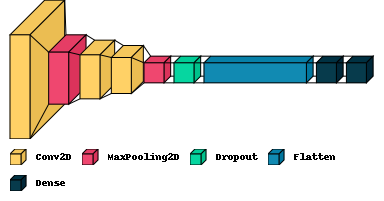

In [48]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(own_augmented_model, legend=True)

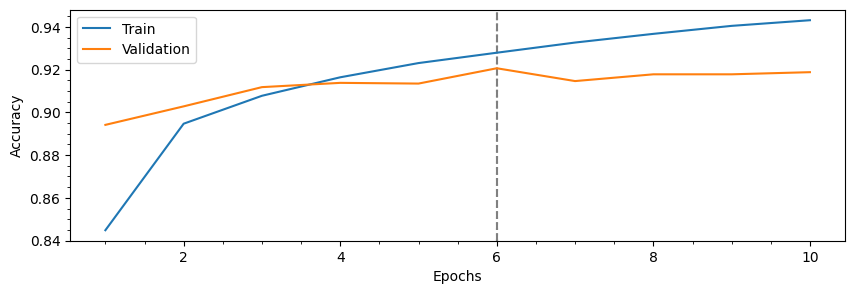

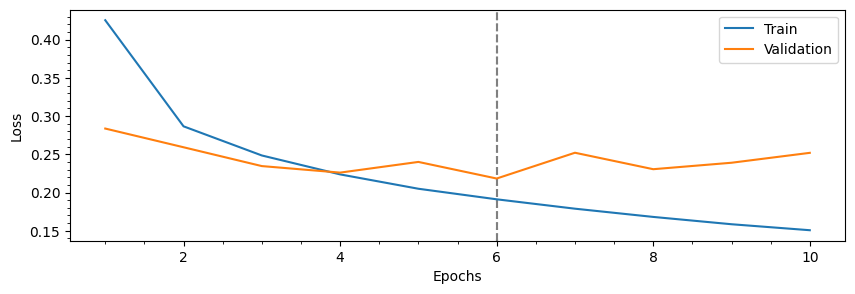

In [49]:
max_val_acc_epoch = np.argmax(list(history_augmented.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(history_augmented.history['val_loss']))+1
epochs = range(1, len(history_augmented.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,history_augmented.history['accuracy'], label='Train')
plt.plot(epochs,history_augmented.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,history_augmented.history['loss'], label='Train')
plt.plot(epochs,history_augmented.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
own_augmented_model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.2574 - accuracy: 0.9183


[0.25744685530662537, 0.9182999730110168]

In [51]:
own_augmented_model.save_weights("models/fashion-own-augmented-model.h5")

## Tensor Core Keras Hyperparameter tuning

In [52]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [53]:
import keras_tuner as kt
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kt\tuner0.json


In [54]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [55]:
tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 448 and the optimal learning rate for the optimizer
is 0.001.



In [56]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train_augmented, y_train_augmented, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
4050/4050 [==============================] - 26s 6ms/step - loss: 0.4751 - accuracy: 0.8272 - val_loss: 0.4934 - val_accuracy: 0.8137
Epoch 2/50
4050/4050 [==============================] - 22s 5ms/step - loss: 0.3614 - accuracy: 0.8664 - val_loss: 0.4339 - val_accuracy: 0.8389
Epoch 3/50
4050/4050 [==============================] - 23s 6ms/step - loss: 0.3273 - accuracy: 0.8790 - val_loss: 0.4559 - val_accuracy: 0.8302
Epoch 4/50
4050/4050 [==============================] - 23s 6ms/step - loss: 0.3043 - accuracy: 0.8865 - val_loss: 0.4417 - val_accuracy: 0.8421
Epoch 5/50
4050/4050 [==============================] - 24s 6ms/step - loss: 0.2847 - accuracy: 0.8929 - val_loss: 0.4225 - val_accuracy: 0.8468
Epoch 6/50
4050/4050 [==============================] - 23s 6ms/step - loss: 0.2727 - accuracy: 0.8982 - val_loss: 0.4248 - val_accuracy: 0.8490
Epoch 7/50
4050/4050 [==============================] - 22s 5ms/step - loss: 0.2601 - accuracy: 0.9022 - val_loss: 0.4038 - val_ac

In [57]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel_history = hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/44
1350/1350 [==============================] - 8s 6ms/step - loss: 0.4951 - accuracy: 0.8234 - val_loss: 0.4583 - val_accuracy: 0.8353
Epoch 2/44
1350/1350 [==============================] - 8s 6ms/step - loss: 0.3743 - accuracy: 0.8646 - val_loss: 0.3512 - val_accuracy: 0.8746
Epoch 3/44
1350/1350 [==============================] - 8s 6ms/step - loss: 0.3338 - accuracy: 0.8771 - val_loss: 0.3828 - val_accuracy: 0.8601
Epoch 4/44
1350/1350 [==============================] - 8s 6ms/step - loss: 0.3088 - accuracy: 0.8864 - val_loss: 0.3629 - val_accuracy: 0.8691
Epoch 5/44
1350/1350 [==============================] - 7s 5ms/step - loss: 0.2876 - accuracy: 0.8937 - val_loss: 0.3226 - val_accuracy: 0.8807
Epoch 6/44
1350/1350 [==============================] - 7s 5ms/step - loss: 0.2712 - accuracy: 0.8986 - val_loss: 0.3199 - val_accuracy: 0.8830
Epoch 7/44
1350/1350 [==============================] - 8s 6ms/step - loss: 0.2583 - accuracy: 0.9036 - val_loss: 0.3186 - val_accuracy:

In [58]:
eval_result = hypermodel.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 2s 5ms/step - loss: 0.5600 - accuracy: 0.8834
[test loss, test accuracy]: [0.5600182414054871, 0.883400022983551]


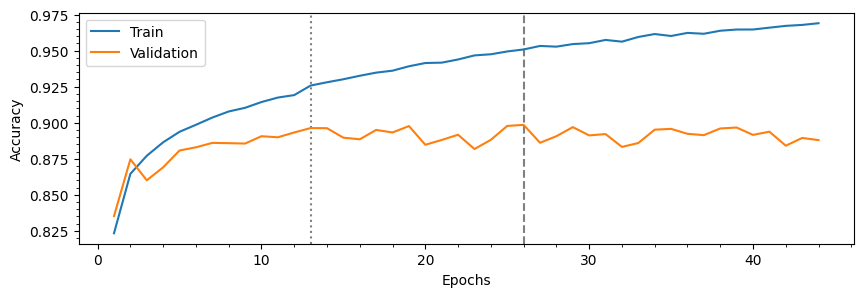

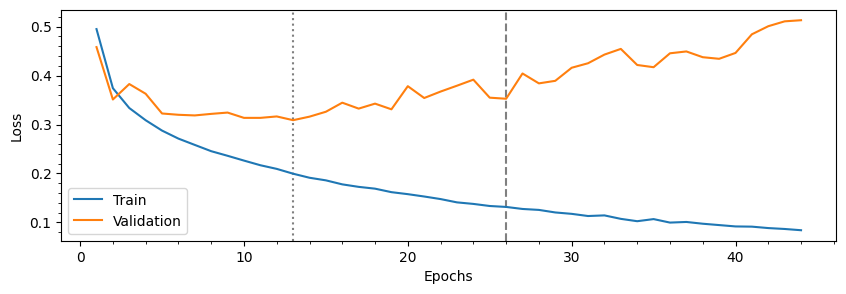

In [59]:
max_val_acc_epoch = np.argmax(list(hypermodel_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(hypermodel_history.history['val_loss']))+1
epochs = range(1, len(hypermodel_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,hypermodel_history.history['accuracy'], label='Train')
plt.plot(epochs,hypermodel_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,hypermodel_history.history['loss'], label='Train')
plt.plot(epochs,hypermodel_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

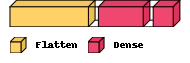

In [60]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(hypermodel, legend=True)

In [61]:
hypermodel.save_weights("models/fashion_hyper_model.h5")

In [ ]:
tuner.search(x_train_augmented, y_train_augmented, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train_augmented, y_train_augmented, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [62]:
hypermodel_augmented = tuner.hypermodel.build(best_hps)
hypermodel_augmented_history = hypermodel_augmented.fit(x_train_augmented, y_train_augmented, epochs=best_epoch, validation_split=0.2)

Epoch 1/44
4050/4050 [==============================] - 23s 6ms/step - loss: 0.4752 - accuracy: 0.8270 - val_loss: 0.4802 - val_accuracy: 0.8247
Epoch 2/44
4050/4050 [==============================] - 22s 5ms/step - loss: 0.3641 - accuracy: 0.8659 - val_loss: 0.4462 - val_accuracy: 0.8428
Epoch 3/44
4050/4050 [==============================] - 22s 5ms/step - loss: 0.3281 - accuracy: 0.8786 - val_loss: 0.4285 - val_accuracy: 0.8461
Epoch 4/44
4050/4050 [==============================] - 23s 6ms/step - loss: 0.3048 - accuracy: 0.8866 - val_loss: 0.4215 - val_accuracy: 0.8437
Epoch 5/44
4050/4050 [==============================] - 23s 6ms/step - loss: 0.2885 - accuracy: 0.8925 - val_loss: 0.4113 - val_accuracy: 0.8490
Epoch 6/44
4050/4050 [==============================] - 22s 6ms/step - loss: 0.2728 - accuracy: 0.8974 - val_loss: 0.4405 - val_accuracy: 0.8373
Epoch 7/44
4050/4050 [==============================] - 23s 6ms/step - loss: 0.2614 - accuracy: 0.9014 - val_loss: 0.4150 - val_ac

In [63]:
eval_result = hypermodel_augmented.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 2s 5ms/step - loss: 0.5518 - accuracy: 0.8920
[test loss, test accuracy]: [0.5517625212669373, 0.8920000195503235]


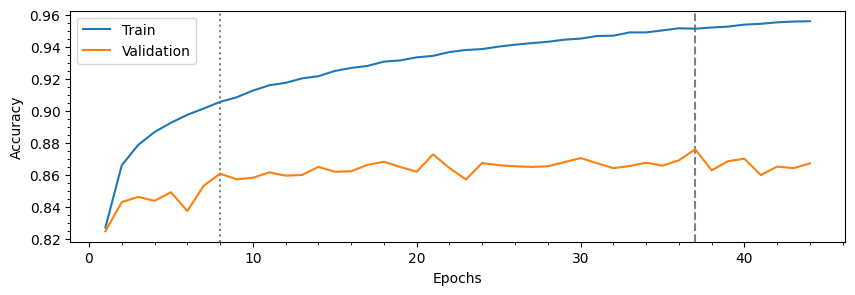

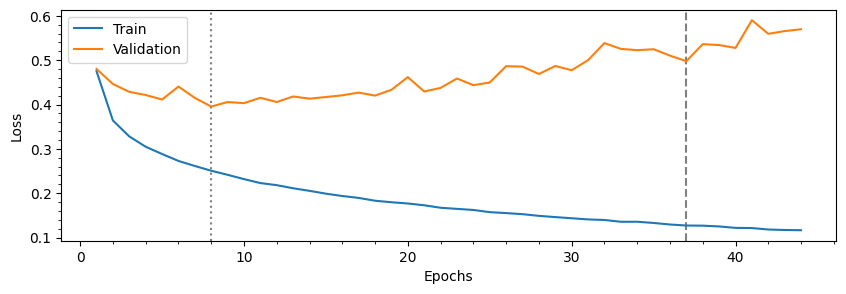

In [64]:
max_val_acc_epoch = np.argmax(list(hypermodel_augmented_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(hypermodel_augmented_history.history['val_loss']))+1
epochs = range(1, len(hypermodel_augmented_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,hypermodel_augmented_history.history['accuracy'], label='Train')
plt.plot(epochs,hypermodel_augmented_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,hypermodel_augmented_history.history['loss'], label='Train')
plt.plot(epochs,hypermodel_augmented_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [73]:
hypermodel.save_weights("models/fashion_hyper_augmented_model.h5")

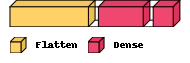

In [74]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(hypermodel_augmented, legend=True)

### Resnet34 architecture

In [65]:
# def identity_block(x, filter):
#     # copy tensor to variable called x_skip
#     x_skip = x
#     # Layer 1
#     x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
#     x = tf.keras.layers.BatchNormalization(axis=3)(x)
#     x = tf.keras.layers.Activation('relu')(x)
#     # Layer 2
#     x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
#     x = tf.keras.layers.BatchNormalization(axis=3)(x)
#     # Add Residue
#     x = tf.keras.layers.Add()([x, x_skip])     
#     x = tf.keras.layers.Activation('relu')(x)
#     return x

In [66]:
# def convolutional_block(x, filter):
#     # copy tensor to variable called x_skip
#     x_skip = x
#     # Layer 1
#     x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
#     x = tf.keras.layers.BatchNormalization(axis=3)(x)
#     x = tf.keras.layers.Activation('relu')(x)
#     # Layer 2
#     x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
#     x = tf.keras.layers.BatchNormalization(axis=3)(x)
#     # Processing Residue with conv(1,1)
#     x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
#     # Add Residue
#     x = tf.keras.layers.Add()([x, x_skip])     
#     x = tf.keras.layers.Activation('relu')(x)
#     return x

In [67]:
# def ResNet34(shape = (32, 32, 3), classes = 10):
#     # Step 1 (Setup Input Layer)
#     x_input = tf.keras.layers.Input(shape)
#     x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
#     # Step 2 (Initial Conv layer along with maxPool)
#     x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation('relu')(x)
#     x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
#     # Define size of sub-blocks and initial filter size
#     block_layers = [3, 4, 6, 3]
#     filter_size = 64
#     # Step 3 Add the Resnet Blocks
#     for i in range(4):
#         if i == 0:
#             # For sub-block 1 Residual/Convolutional block not needed
#             for j in range(block_layers[i]):
#                 x = identity_block(x, filter_size)
#         else:
#             # One Residual/Convolutional Block followed by Identity blocks
#             # The filter size will go on increasing by a factor of 2
#             filter_size = filter_size*2
#             x = convolutional_block(x, filter_size)
#             for j in range(block_layers[i] - 1):
#                 x = identity_block(x, filter_size)
#     # Step 4 End Dense Network
#     x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
#     x = tf.keras.layers.Flatten()(x)
#     x = tf.keras.layers.Dense(512, activation = 'relu')(x)
#     x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
#     model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
#     return model


In [68]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.summary()
# model.fit(x_train_augmented, y_train_augmented, epochs=10, validation_data=(x_val, y_val))
# model

In [69]:
# accuracy_val = history_augmented.history['val_accuracy']
# accuracy = history_augmented.history['accuracy']
# epoch = range(0,10)
# plt.plot(epoch, accuracy, 'g', label='accuracy')
# plt.plot(epoch, accuracy_val, 'b', label='validation accuracy')
# plt.title('Training and Validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('accuracy')
# plt.legend()
# plt.show()

In [70]:
# loss_val = history_augmented.history['val_loss']
# loss = history_augmented.history['loss']
# epoch = range(0,10)
# plt.plot(epoch, loss, 'g', label='loss')
# plt.plot(epoch, loss_val, 'b', label='validation loss')
# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [71]:
# # plot diagnostic learning curves
# def summarize_diagnostics(history_augmented):
# 	for i in range(len(histories)):
# 		# plot loss
# 		pyplot.subplot(211)
# 		pyplot.title('Cross Entropy Loss')
# 		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
# 		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
# 		# plot accuracy
# 		pyplot.subplot(212)
# 		pyplot.title('Classification Accuracy')
# 		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
# 		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
# 	pyplot.show()
 
# # summarize model performance
# def summarize_performance(accuracy):
# 	# print summary
# 	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
# 	# box and whisker plots of results
# 	pyplot.boxplot(scores)
# 	pyplot.show()
 
# # run the test harness for evaluating a model
# def run_test_harness():
# 	# load dataset
# 	trainX, trainY, testX, testY = load_dataset()
# 	# prepare pixel data
# 	trainX, testX = prep_pixels(trainX, testX)
# 	# evaluate model
# 	scores, histories = evaluate_model(trainX, trainY)
# 	# learning curves
# 	summarize_diagnostics(histories)
# 	# summarize estimated performance
# 	summarize_performance(scores)
 
# # entry point, run the test harness
# run_test_harness()

In [72]:
# # resnet 50 but augmented data

# resnet50_augmented_model = resnet50()
# resnet50_augmented_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
#                        metrics=['acc'])

# train_augmented_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
#                                                                 width_shift_range=0.1, 
#                                                                 height_shift_range = 0.1, 
#                                                                 horizontal_flip=True)
# batch_size=64

# train_labels_augmented_categorical = tf.keras.utils.to_categorical(
#     y_train_augmented, num_classes=10, dtype='uint8')

# train_augmented_set_conv = train_augmented_DataGen.flow(x_train_augmented.reshape((*x_train_augmented.shape,1)), train_labels_augmented_categorical, batch_size=batch_size)

# resnet_history = resnet50_model.fit(train_augmented_set_conv, epochs=100)